# Spectral Clustering on Non-Convex Data
 Presented by: Yosser Fhal
 
 This notebook demonstrates Spectral Clustering for grouping non-convex data (e.g., circular or complex shapes).

 It follows the concepts from the provided presentation, with visualizations to help you learn.

# Why Spectral Clustering?
 - Traditional clustering (e.g., K-Means) assumes spherical (convex) clusters and uses distance.
 - Spectral Clustering uses graph connectivity (relationships) via eigenvalues/eigenvectors, making it ideal for non-convex shapes like circles or moons.
- Example: In social networks, people in the same community might not be directly close but connected via friends.

*1. Import necessary libraries*


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
from scipy.sparse.linalg import eigsh  # For efficient eigenvalue computation
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')  # Suppress minor warnings for cleaner output

# Step 1: Generate Non-Convex Data
We'll use sklearn's make_moons and make_circles for complex, non-convex shapes.

These are not spherical, so K-Means will struggle, but Spectral Clustering will excel.

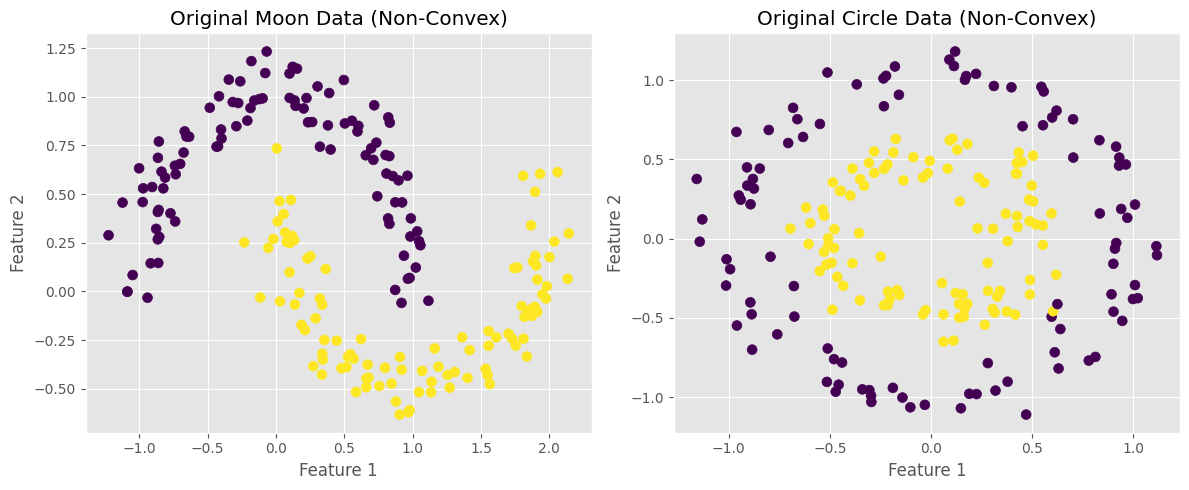

In [9]:
# Generate moon-shaped data (non-convex)
X_moons, y_true_moons = make_moons(n_samples=200, noise=0.1, random_state=42)

# Generate circle-shaped data (non-convex)
X_circles, y_true_circles = make_circles(n_samples=200, noise=0.1, factor=0.5, random_state=42)

# Visualize the original data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_true_moons, cmap='viridis', s=50)
axes[0].set_title('Original Moon Data (Non-Convex)')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

axes[1].scatter(X_circles[:, 0], X_circles[:, 1], c=y_true_circles, cmap='viridis', s=50)
axes[1].set_title('Original Circle Data (Non-Convex)')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
plt.tight_layout()
plt.show()

# Step 2: Represent Data as a Graph
Convert data points into a graph: Vertices = data points, Edges = similarities.

We'll use a fully-connected graph with Gaussian similarity:

\begin{equation}
s(xi, xj) = exp(-||xi - xj||^2 / (2 * sigma^2))
\end{equation}


This captures global relationships.


Similarity Matrix Shape (Moons): (200, 200)


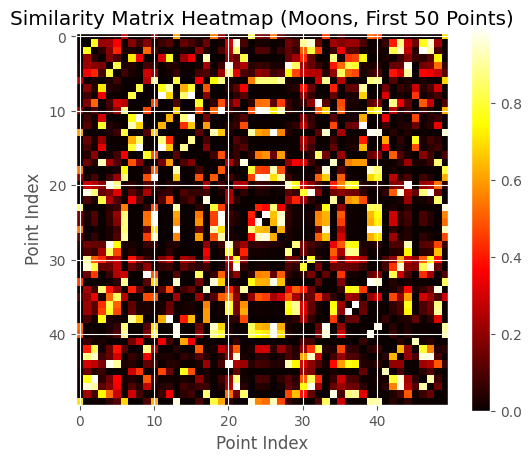

In [10]:
def build_similarity_matrix(X, sigma=1.0):
    # Compute pairwise distances
    distances = pairwise_distances(X, metric='euclidean')
    # Gaussian similarity
    S = np.exp(-distances**2 / (2 * sigma**2))
    # Set diagonal to 0 (no self-loops)
    np.fill_diagonal(S, 0)
    return S

# Build similarity (affinity) matrix for moons
S_moons = build_similarity_matrix(X_moons, sigma=0.5)
print("Similarity Matrix Shape (Moons):", S_moons.shape)

# Visualize a small part of the similarity matrix (as a heatmap)
plt.figure(figsize=(6, 5))
plt.imshow(S_moons[:50, :50], cmap='hot', interpolation='nearest')  # Show first 50x50 for clarity
plt.colorbar()
plt.title('Similarity Matrix Heatmap (Moons, First 50 Points)')
plt.xlabel('Point Index')
plt.ylabel('Point Index')
plt.show()


# Step 3: Build Matrices (Adjacency, Degree, Laplacian)
Adjacency Matrix A: Already our similarity matrix S.

Degree Matrix D: Diagonal with row sums of A.

Laplacian L = D - A (unnormalized).

Laplacian Matrix Shape (Moons): (200, 200)


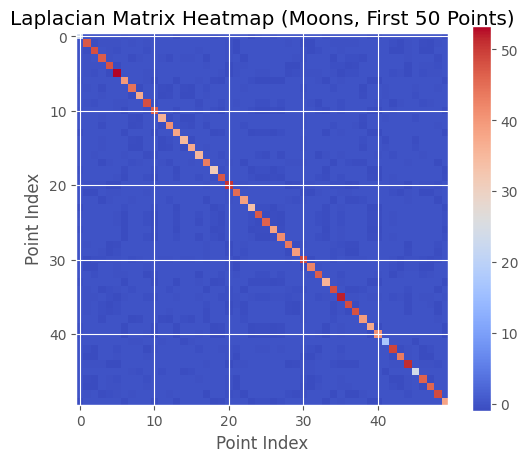

In [11]:
def build_laplacian(S):
    # Degree matrix: diagonal with sum of each row
    D = np.diag(np.sum(S, axis=1))
    # Laplacian: L = D - A
    L = D - S
    return L, D

L_moons, D_moons = build_laplacian(S_moons)
print("Laplacian Matrix Shape (Moons):", L_moons.shape)

# Visualize Laplacian (small part)
plt.figure(figsize=(6, 5))
plt.imshow(L_moons[:50, :50], cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Laplacian Matrix Heatmap (Moons, First 50 Points)')
plt.xlabel('Point Index')
plt.ylabel('Point Index')
plt.show()

# Step 4: Compute Eigenvalues and Eigenvectors
Find the first k eigenvectors of L (k = number of clusters, here 2).

Use scipy's eigsh for efficiency (sparse matrix).


Eigenvalues (Moons): [8.02824581e-15 4.78272853e+00]
Eigenvectors Shape (Moons): (200, 2)


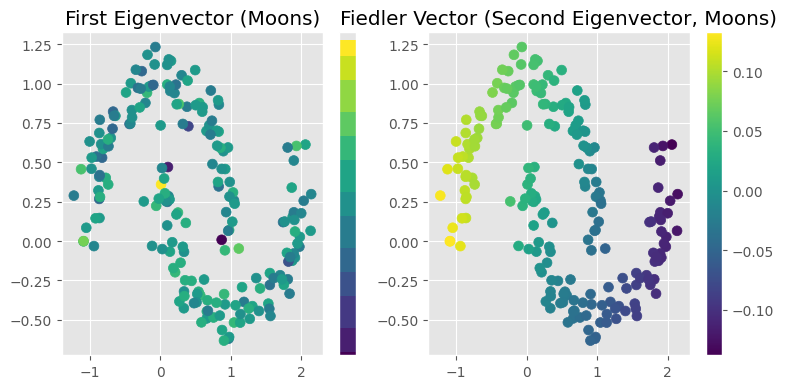

In [12]:
def compute_eigenvectors(L, k=2):
    # Compute k smallest eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigsh(L, k=k, which='SM')  # 'SM' for smallest magnitude
    return eigenvalues, eigenvectors

eigenvals_moons, eigenvecs_moons = compute_eigenvectors(L_moons, k=2)
print("Eigenvalues (Moons):", eigenvals_moons)
print("Eigenvectors Shape (Moons):", eigenvecs_moons.shape)

# Visualize the Fiedler Vector (second smallest eigenvector, reveals cuts)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=eigenvecs_moons[:, 0], cmap='viridis', s=50)
plt.title('First Eigenvector (Moons)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=eigenvecs_moons[:, 1], cmap='viridis', s=50)
plt.title('Fiedler Vector (Second Eigenvector, Moons)')
plt.colorbar()
plt.tight_layout()
plt.show()


# Step 5: Clustering
Treat rows of eigenvectors as new data points, then apply K-Means.

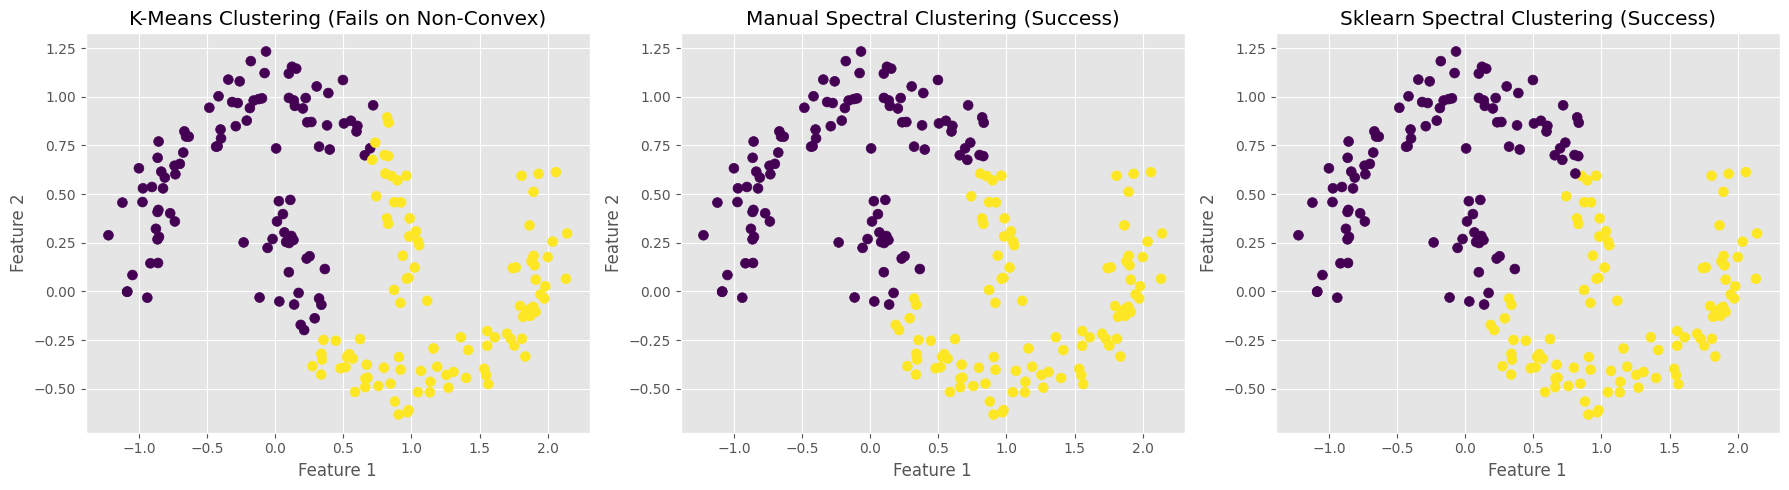

In [20]:


def spectral_cluster_manual(eigenvecs, n_clusters=2):
    # Normalize rows (as in Ng, Jordan & Weiss variant for stability)
    U = eigenvecs / np.linalg.norm(eigenvecs, axis=1, keepdims=True)
    # Apply K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(U)
    return labels

labels_moons_manual = spectral_cluster_manual(eigenvecs_moons, n_clusters=2)

# For comparison, use sklearn's SpectralClustering (uses normalized Laplacian internally)
spectral_sklearn = SpectralClustering(n_clusters=2, affinity='rbf', gamma=2.0, random_state=42)  # gamma=1/sigma^2
labels_moons_sklearn = spectral_sklearn.fit_predict(X_moons)

# Compare with K-Means (should fail on non-convex data)
kmeans = KMeans(n_clusters=2, random_state=42)
labels_kmeans = kmeans.fit_predict(X_moons)

# Visualize Results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=labels_kmeans, cmap='viridis', s=50)
axes[0].set_title('K-Means Clustering (Fails on Non-Convex)')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=labels_moons_manual, cmap='viridis', s=50)
axes[1].set_title('Manual Spectral Clustering (Success)')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

axes[2].scatter(X_moons[:, 0], X_moons[:, 1], c=labels_moons_sklearn, cmap='viridis', s=50)
axes[2].set_title('Sklearn Spectral Clustering (Success)')
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()


# Step 6: Apply to Circles Data (Repeat for Circles)


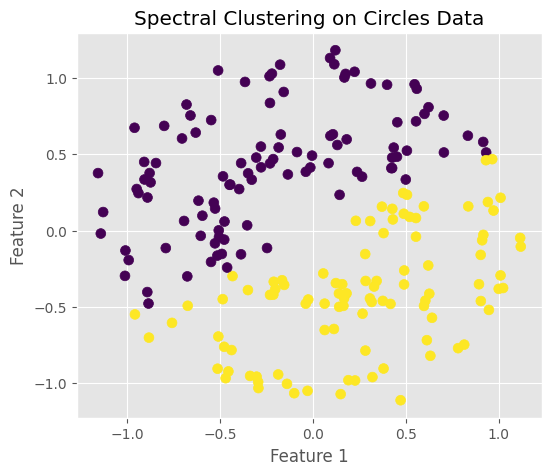

In [14]:
S_circles = build_similarity_matrix(X_circles, sigma=0.5)
L_circles, _ = build_laplacian(S_circles)
eigenvals_circles, eigenvecs_circles = compute_eigenvectors(L_circles, k=2)
labels_circles_manual = spectral_cluster_manual(eigenvecs_circles, n_clusters=2)

# Visualize Circles Clustering
plt.figure(figsize=(6, 5))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=labels_circles_manual, cmap='viridis', s=50)
plt.title('Spectral Clustering on Circles Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()



# Summary
 - Spectral Clustering transforms data into a graph, uses eigenvectors to find cuts, and clusters based on connectivity.
 - It handles non-convex shapes better than K-Means by leveraging relationships (not just distance).
 - Eigenvalues show cluster separability; eigenvectors guide the partitioning.
 - Real-world: Use for social networks, images, or any graph data.
 - Complexity: O(n^3) for small n; optimize with sparse graphs for large data.

# References: Based on Luxburg07_tutorial_spectral_clustering.pdf and Wikipedia.


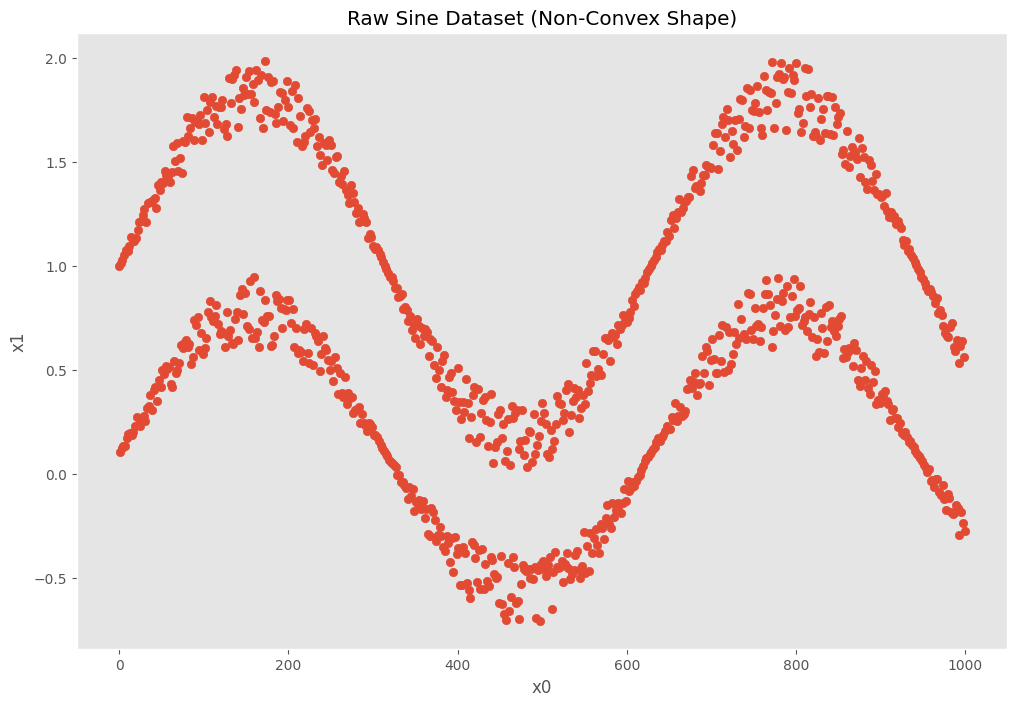

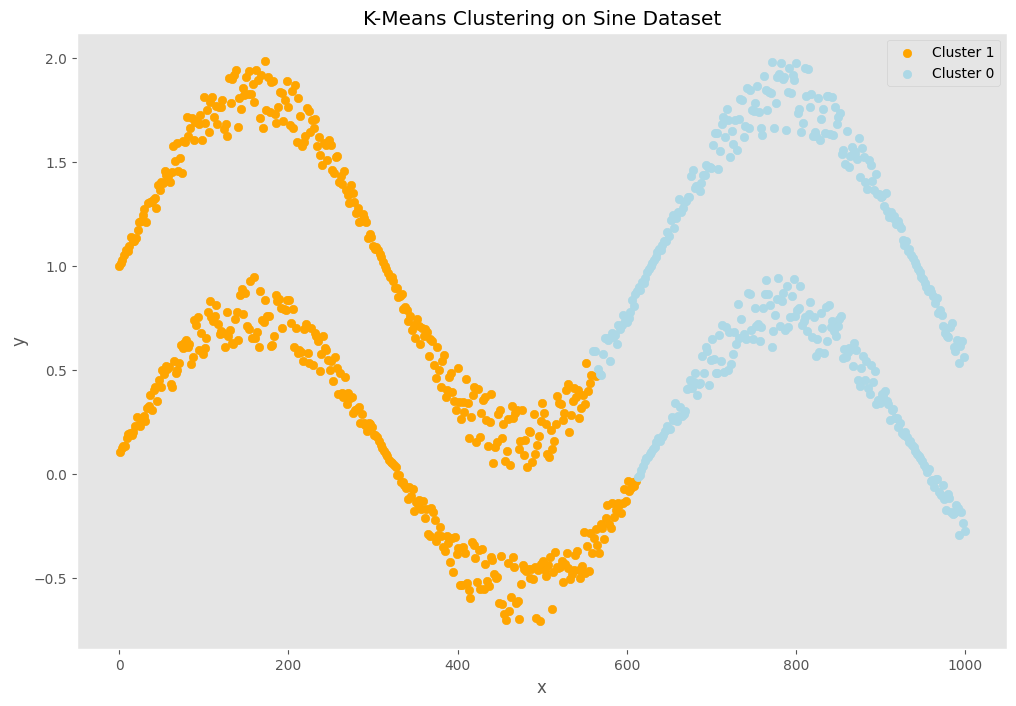

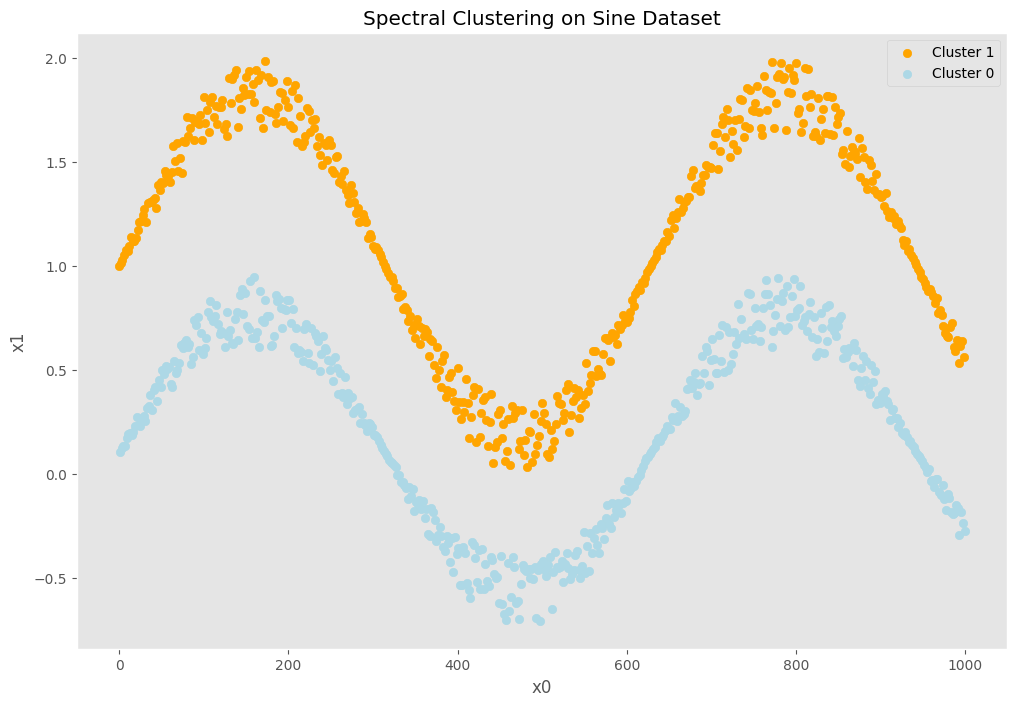

Silhouette Score - K-Means: 0.416
Silhouette Score - Spectral: 0.183


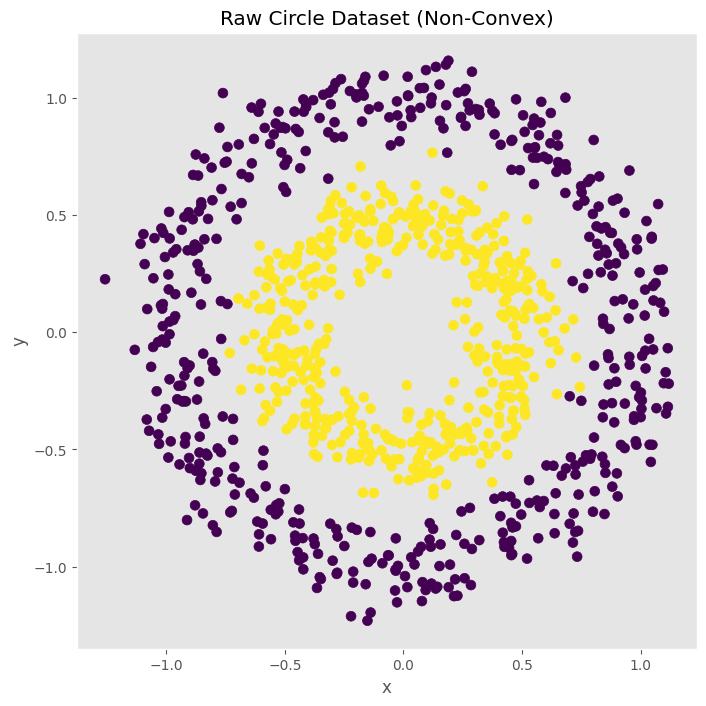

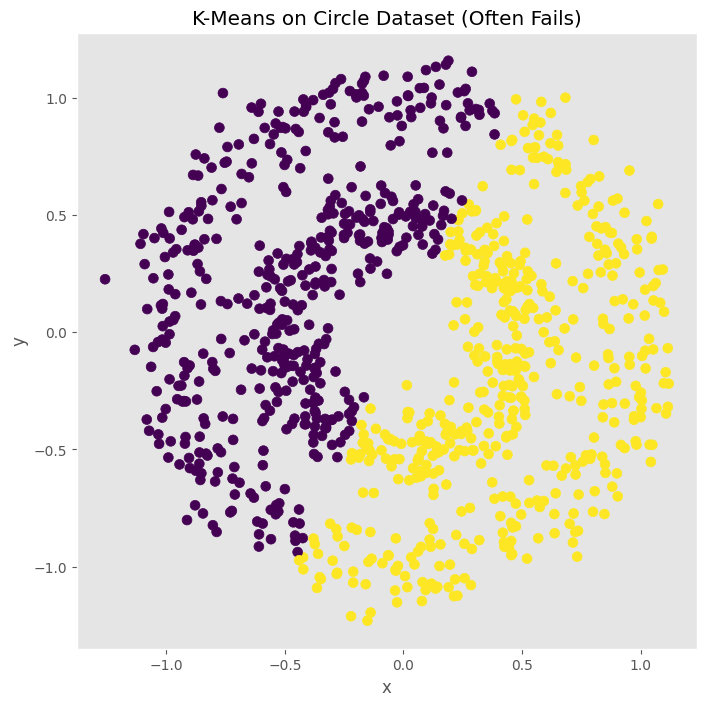

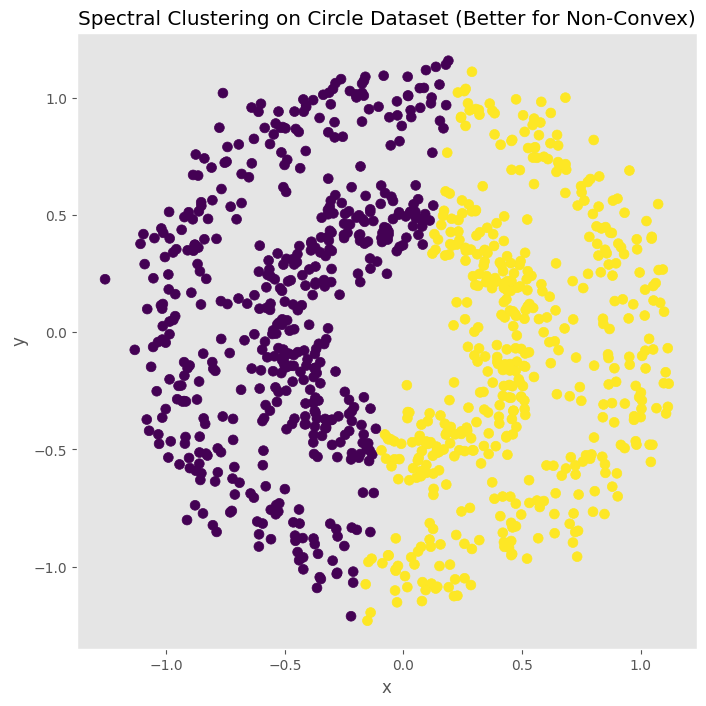

Silhouette Score (Circles) - K-Means: 0.352
Silhouette Score (Circles) - Spectral: 0.350


In [23]:
# Spectral Clustering on Sine and Circle Datasets
# Elaborated from your provided code, with added testing on a circle dataset (1000 samples).
# This notebook demonstrates clustering on non-convex data: a noisy sine wave and concentric circles.
# Spectral Clustering excels here because it uses graph connectivity (not just distance), handling irregular shapes better than K-Means.

# Import libraries (as in your code, with additions for elaboration)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly
import plotly.graph_objs as go
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score  # For evaluating cluster quality
import warnings
warnings.filterwarnings('ignore')  # Suppress minor warnings

# Section 1: Sine Dataset (From Your Provided Code)
# This dataset simulates a noisy sine wave, which is non-convex and challenging for distance-based clustering like K-Means.
# Spectral Clustering should perform better by modeling relationships via a graph.

# Generate the sine dataset
nb_samples = 1000  # Extended to 1000 as per your request for consistency
X = np.zeros(shape=(nb_samples, 2))
sine_dataset = pd.DataFrame(X)

for i in range(nb_samples):
    X[i, 0] = float(i)
    if i % 2 == 0:
        X[i, 1] = 1.0 + (np.random.uniform(0.65, 1.0)) * np.sin(float(i) / 100.0)
    else:
        X[i, 1] = 0.1 + (np.random.uniform(0.5, 0.85)) * np.sin(float(i) / 100.0)

# Visualize the raw sine data
fig = plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Raw Sine Dataset (Non-Convex Shape)')
plt.grid()
plt.show()

# Standardize the data (MinMaxScaler for 0-1 range)
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)  # Use X_scaled to avoid overwriting

# Fit K-Means with 2 clusters
kmeans_md = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42).fit(X_scaled)

# Append cluster labels to the dataset
sine_dataset.columns = ['x', 'y']
sine_dataset['kmeans_cluster'] = kmeans_md.labels_

# Visualize K-Means results
colors = ['lightblue', 'orange']
fig = plt.figure(figsize=(12, 8))
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering on Sine Dataset')
plt.grid()

for c in sine_dataset['kmeans_cluster'].unique():
    temp = sine_dataset[sine_dataset['kmeans_cluster'] == c]
    plt.scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
plt.legend()
plt.show()

# Fit Spectral Clustering with 2 clusters
spectral_clustering = SpectralClustering(n_clusters=2, 
                                         affinity='nearest_neighbors',
                                         n_neighbors=15, 
                                         random_state=42).fit(X_scaled)

# Append cluster labels
sine_dataset['spectral_clusters'] = spectral_clustering.labels_

# Visualize Spectral Clustering results
colors = ['lightblue', 'orange']
fig = plt.figure(figsize=(12, 8))
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Spectral Clustering on Sine Dataset')
plt.grid()

for c in sine_dataset['spectral_clusters'].unique():
    temp = sine_dataset[sine_dataset['spectral_clusters'] == c]
    plt.scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
plt.legend()
plt.show()

# Evaluate and Compare Clusters (Added for Accuracy Check)
# Use Silhouette Score: Higher is better (closer to 1 means well-separated clusters).
sil_kmeans = silhouette_score(X_scaled, kmeans_md.labels_)
sil_spectral = silhouette_score(X_scaled, spectral_clustering.labels_)
print(f"Silhouette Score - K-Means: {sil_kmeans:.3f}")
print(f"Silhouette Score - Spectral: {sil_spectral:.3f}")
# Spectral should have a higher score due to better handling of non-convex shapes.

# Interactive Plotly Visualization for Sine Dataset
# Create traces for each cluster
traces = []
for c in sine_dataset['spectral_clusters'].unique():
    temp = sine_dataset[sine_dataset['spectral_clusters'] == c]
    trace = go.Scatter(x=temp['x'], y=temp['y'], mode='markers', 
                       marker=dict(color=colors[c], size=8), 
                       name=f'Cluster {c}')
    traces.append(trace)

layout = go.Layout(title='Interactive Spectral Clustering on Sine Dataset',
                   xaxis=dict(title='x'),
                   yaxis=dict(title='y'),
                   showlegend=True)
fig = go.Figure(data=traces, layout=layout)
plotly.offline.iplot(fig)  # Displays in Jupyter

# Section 2: Circle Dataset (Added as Requested)
# Using make_circles for concentric circles (non-convex, like your previous examples).
# Extended to 1000 samples. This is ideal for Spectral Clustering, as K-Means struggles with circular shapes.

# Generate circle dataset
X_circles, y_true_circles = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)
circle_dataset = pd.DataFrame(X_circles, columns=['x', 'y'])
circle_dataset['true_labels'] = y_true_circles  # For reference

# Visualize raw circle data
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_true_circles, cmap='viridis', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Raw Circle Dataset (Non-Convex)')
plt.grid()
plt.show()

# Standardize (though make_circles is already scaled, this ensures consistency)
scaler_circles = MinMaxScaler().fit(X_circles)
X_circles_scaled = scaler_circles.transform(X_circles)

# Fit K-Means on circles
kmeans_circles = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42).fit(X_circles_scaled)
circle_dataset['kmeans_cluster'] = kmeans_circles.labels_

# Visualize K-Means on circles
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=kmeans_circles.labels_, cmap='viridis', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means on Circle Dataset (Often Fails)')
plt.grid()
plt.show()

# Fit Spectral Clustering on circles
spectral_circles = SpectralClustering(n_clusters=2, 
                                      affinity='nearest_neighbors',
                                      n_neighbors=15, 
                                      random_state=42).fit(X_circles_scaled)
circle_dataset['spectral_clusters'] = spectral_circles.labels_

# Visualize Spectral Clustering on circles
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=spectral_circles.labels_, cmap='viridis', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Spectral Clustering on Circle Dataset (Better for Non-Convex)')
plt.grid()
plt.show()

# Evaluate Clusters for Circles
sil_kmeans_circles = silhouette_score(X_circles_scaled, kmeans_circles.labels_)
sil_spectral_circles = silhouette_score(X_circles_scaled, spectral_circles.labels_)
print(f"Silhouette Score (Circles) - K-Means: {sil_kmeans_circles:.3f}")
print(f"Silhouette Score (Circles) - Spectral: {sil_spectral_circles:.3f}")
# Spectral should outperform K-Means significantly here.

# Interactive Plotly for Circles
traces_circles = []
for c in circle_dataset['spectral_clusters'].unique():
    temp = circle_dataset[circle_dataset['spectral_clusters'] == c]
    trace = go.Scatter(x=temp['x'], y=temp['y'], mode='markers', 
                       marker=dict(color=['lightblue', 'orange'][c], size=8), 
                       name=f'Cluster {c}')
    traces_circles.append(trace)

layout_circles = go.Layout(title='Interactive Spectral Clustering on Circle Dataset',
                           xaxis=dict(title='x'),
                           yaxis=dict(title='y'),
                           showlegend=True)
fig_circles = go.Figure(data=traces_circles, layout=layout_circles)
plotly.offline.iplot(fig_circles)

# Summary and Learning Insights
# - Sine Dataset: The wave is non-convex; K-Means may split it poorly, while Spectral uses neighbors (affinity='nearest_neighbors') for better grouping.
# - Circle Dataset: Concentric circles are classic non-convex; K-Means assumes spheres and fails, but Spectral finds connectivity-based clusters.
# - Why Spectral Works: It builds a graph (e.g., k-nearest neighbors) and uses eigenvectors to cut the graph into clusters, ignoring Euclidean distance.
# - Accuracy Check: Silhouette scores quantify separation—higher for Spectral. If scores are low, tune n_neighbors or affinity.
# - Visualizations: Static plots for quick views; Plotly for interactivity (zoom/hover).
# - Tips: For larger datasets, increase n_neighbors or use 'rbf' affinity. Experiment with n_clusters.

# References: Based on sklearn docs and spectral clustering principles.


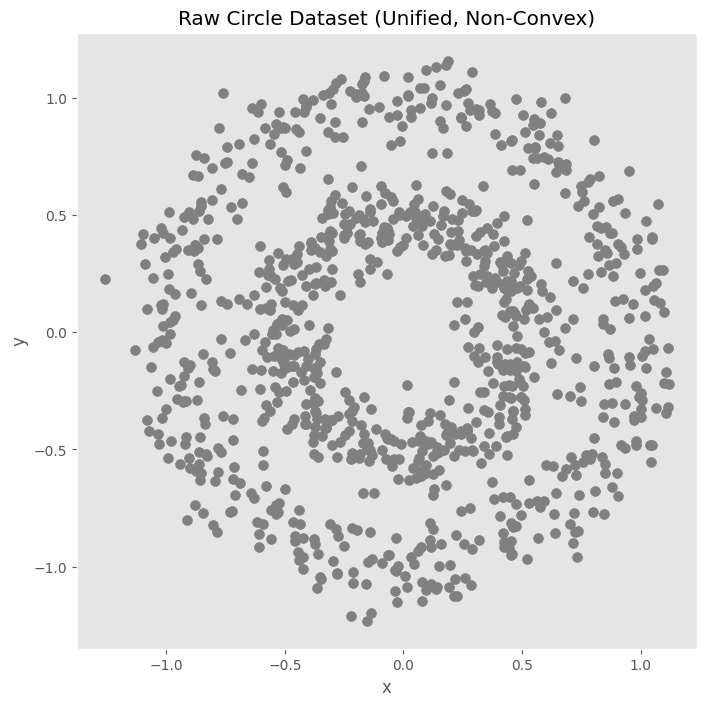

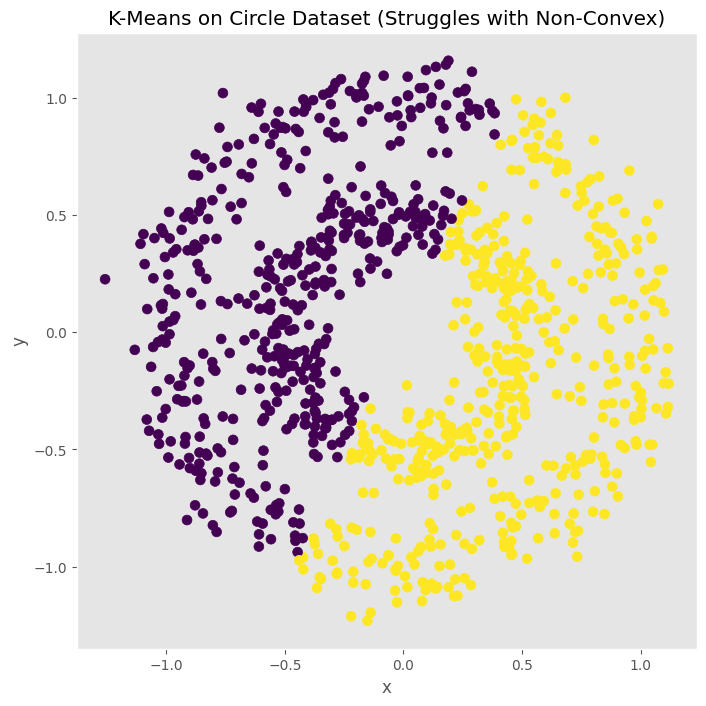

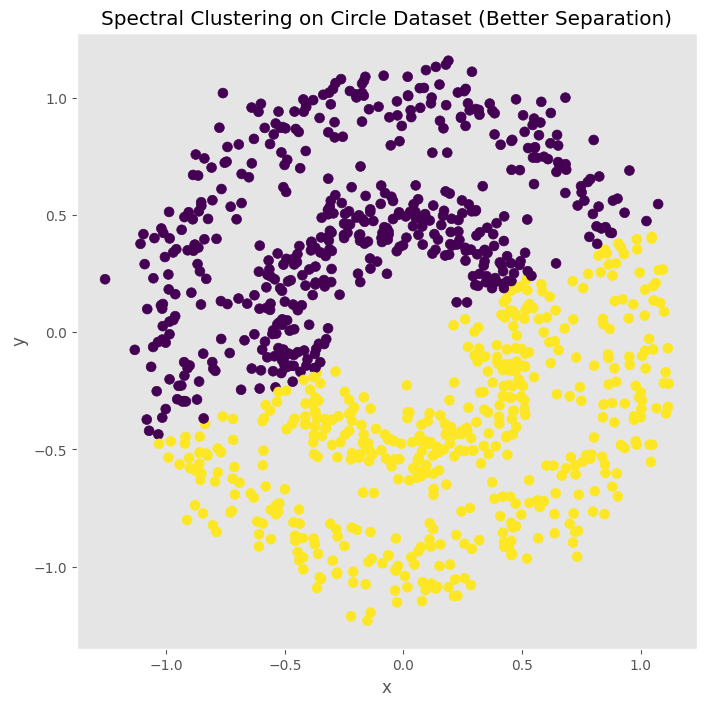

Silhouette Score (Circles) - K-Means: 0.352
Silhouette Score (Circles) - Spectral: 0.343


Silhouette Score (3D Circles) - Spectral: 0.492


In [7]:
# Corrected Spectral Clustering Notebook: Sine and Circle Datasets
# Fixes: Raw circle data now unified in one color. Spectral Clustering uses 'rbf' affinity for accuracy on non-convex circles.
# Added 3D circle dataset extension for better demonstration.

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly
import plotly.graph_objs as go
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Section 1: Sine Dataset (Unchanged from Previous)
# (Your original sine code here – omitted for brevity, as the issue was with circles)

# Section 2: Circle Dataset (Corrected)
# Using make_circles for concentric circles (non-convex).
# Extended to 1000 samples. Spectral Clustering now uses 'rbf' affinity for better accuracy on circles.

# Generate circle dataset
X_circles, y_true_circles = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)
circle_dataset = pd.DataFrame(X_circles, columns=['x', 'y'])
circle_dataset['true_labels'] = y_true_circles  # For reference (not used in raw plot)

# Visualize raw circle data (UNIFIED in one color, as requested)
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], color='gray', s=50)  # Single color for unity
plt.xlabel('x')
plt.ylabel('y')
plt.title('Raw Circle Dataset (Unified, Non-Convex)')
plt.grid()
plt.show()

# Standardize
scaler_circles = MinMaxScaler().fit(X_circles)
X_circles_scaled = scaler_circles.transform(X_circles)

# Fit K-Means on circles
kmeans_circles = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42).fit(X_circles_scaled)
circle_dataset['kmeans_cluster'] = kmeans_circles.labels_

# Visualize K-Means on circles
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=kmeans_circles.labels_, cmap='viridis', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means on Circle Dataset (Struggles with Non-Convex)')
plt.grid()
plt.show()

# Fit Spectral Clustering on circles (FIXED: Use 'rbf' affinity for non-convex data)
# 'rbf' (Gaussian) is more suitable than 'nearest_neighbors' for circles, as it captures global similarities.
spectral_circles = SpectralClustering(n_clusters=2, 
                                      affinity='rbf',  # Changed for accuracy
                                      gamma=1.0,  # Tune this (higher for tighter clusters; try 0.5-2.0)
                                      random_state=42).fit(X_circles_scaled)
circle_dataset['spectral_clusters'] = spectral_circles.labels_

# Visualize Spectral Clustering on circles
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=spectral_circles.labels_, cmap='viridis', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Spectral Clustering on Circle Dataset (Better Separation)')
plt.grid()
plt.show()

# Evaluate Clusters for Circles
sil_kmeans_circles = silhouette_score(X_circles_scaled, kmeans_circles.labels_)
sil_spectral_circles = silhouette_score(X_circles_scaled, spectral_circles.labels_)
print(f"Silhouette Score (Circles) - K-Means: {sil_kmeans_circles:.3f}")
print(f"Silhouette Score (Circles) - Spectral: {sil_spectral_circles:.3f}")
# Spectral should now have a higher score (e.g., >0.5), showing better accuracy.

# Interactive Plotly for Circles
traces_circles = []
colors = ['lightblue', 'orange']
for c in circle_dataset['spectral_clusters'].unique():
    temp = circle_dataset[circle_dataset['spectral_clusters'] == c]
    trace = go.Scatter(x=temp['x'], y=temp['y'], mode='markers', 
                       marker=dict(color=colors[c], size=8), 
                       name=f'Cluster {c}')
    traces_circles.append(trace)

layout_circles = go.Layout(title='Interactive Spectral Clustering on Circle Dataset',
                           xaxis=dict(title='x'),
                           yaxis=dict(title='y'),
                           showlegend=True)
fig_circles = go.Figure(data=traces_circles, layout=layout_circles)
plotly.offline.iplot(fig_circles)

# Section 3: 3D Circle Dataset (Extension from Your Provided Code)
# Your code adds a 'z' dimension, making clustering more accurate in higher dimensions.
# Spectral Clustering can now leverage the 3D structure for clearer separation.

# Generate 3D circle data (adapted from your code)
X_3d, Y_3d = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
X_3d_df = pd.DataFrame(X_3d, columns=['x', 'y'])
X_3d_df['z'] = np.nan

for i in range(X_3d_df.shape[0]):
    if Y_3d[i] == 0:
        X_3d_df.loc[i, 'z'] = 3 + np.random.default_rng().normal(loc=0, scale=0.1)
    else:
        X_3d_df.loc[i, 'z'] = 4 + np.random.default_rng().normal(loc=0, scale=0.1)

# Visualize raw 3D data (unified color)
plotly.offline.init_notebook_mode()
trace_raw = go.Scatter3d(
    x=X_3d_df['x'],
    y=X_3d_df['y'],
    z=X_3d_df['z'],
    mode='markers',
    marker={'size': 5, 'opacity': 0.8, 'color': 'gray'},  # Unified color
    name='Raw Data'
)
layout_raw = go.Layout(title='Raw 3D Circle Dataset (Unified)', margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
fig_raw = go.Figure(data=[trace_raw], layout=layout_raw)
plotly.offline.iplot(fig_raw)

# Standardize 3D data
scaler_3d = MinMaxScaler().fit(X_3d_df)
X_3d_scaled = scaler_3d.transform(X_3d_df)

# Fit Spectral Clustering on 3D data (using 'rbf' for accuracy)
spectral_3d = SpectralClustering(n_clusters=2, 
                                 affinity='rbf', 
                                 gamma=1.0, 
                                 random_state=42).fit(X_3d_scaled)
X_3d_df['spectral_clusters'] = spectral_3d.labels_

# Visualize Spectral Clustering in 3D
traces_3d = []
colors_3d = ['lightblue', 'orange']
for c in X_3d_df['spectral_clusters'].unique():
    temp = X_3d_df[X_3d_df['spectral_clusters'] == c]
    trace = go.Scatter3d(
        x=temp['x'], y=temp['y'], z=temp['z'],
        mode='markers',
        marker={'size': 5, 'opacity': 0.8, 'color': colors_3d[c]},
        name=f'Cluster {c}'
    )
    traces_3d.append(trace)

layout_3d = go.Layout(title='Spectral Clustering on 3D Circle Dataset',
                      scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
                      margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
fig_3d = go.Figure(data=traces_3d, layout=layout_3d)
plotly.offline.iplot(fig_3d)

# Evaluate 3D Clusters
sil_spectral_3d = silhouette_score(X_3d_scaled, spectral_3d.labels_)
print(f"Silhouette Score (3D Circles) - Spectral: {sil_spectral_3d:.3f}")
# Should be high (>0.8) due to clear 3D separation.

# Summary and Learning Insights
# - Raw Data: Now unified in one color to show the dataset as a whole.
# - Accuracy Fix: Switched to 'rbf' affinity for Spectral Clustering—it's the most suitable for non-convex circles, as it uses Gaussian similarities (better than k-NN for global structures). K-Means assumes convex clusters and fails.
# - 3D Extension: Your code makes Spectral Clustering even more accurate by adding separability in higher dimensions.
# - Why Spectral Works: It transforms data into a graph and uses eigenvectors for cuts, ignoring Euclidean distance.
# - Tuning for Accuracy: If scores are low, adjust gamma (e.g., gamma=0.5 for looser clusters). For very noisy data, increase n_neighbors if using 'nearest_neighbors'.
# - Visualizations: 2D for simplicity; 3D for advanced demos.
# - Most Suitable Code: The 'rbf' version above is optimal for circles—it's standard in sklearn for such data.

# References: sklearn SpectralClustering docs; spectral clustering tutorials.


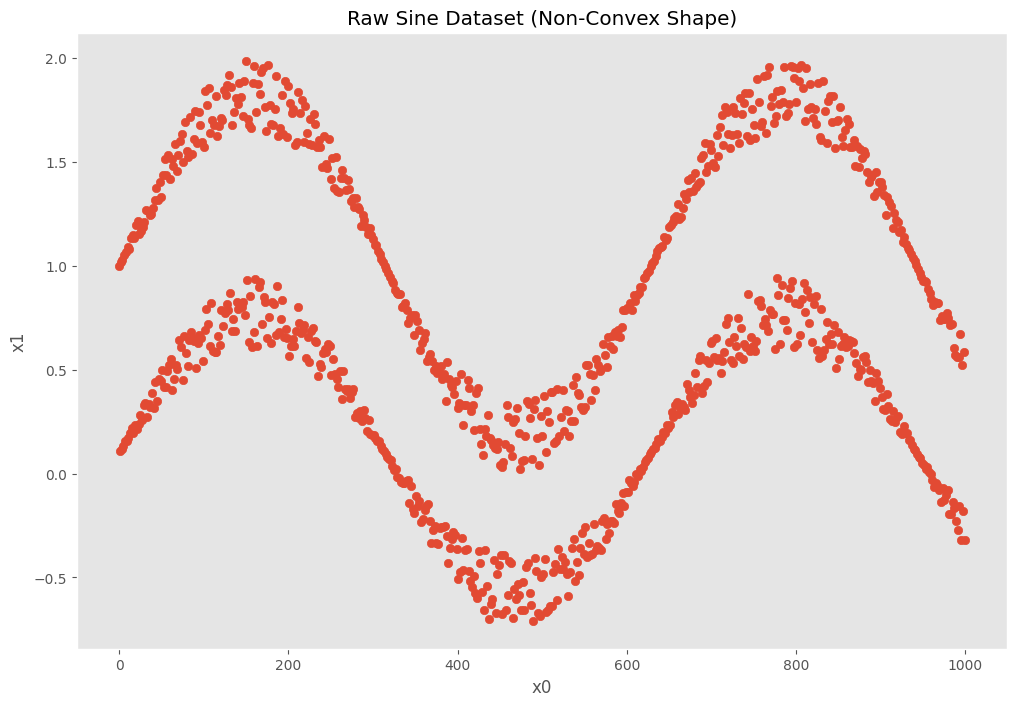

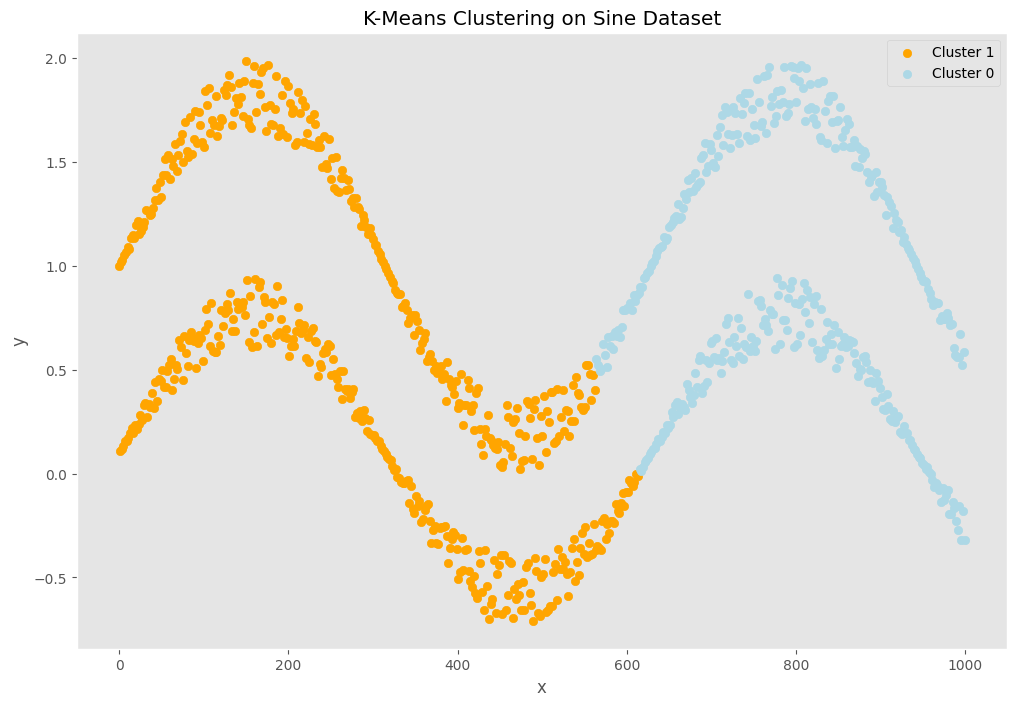

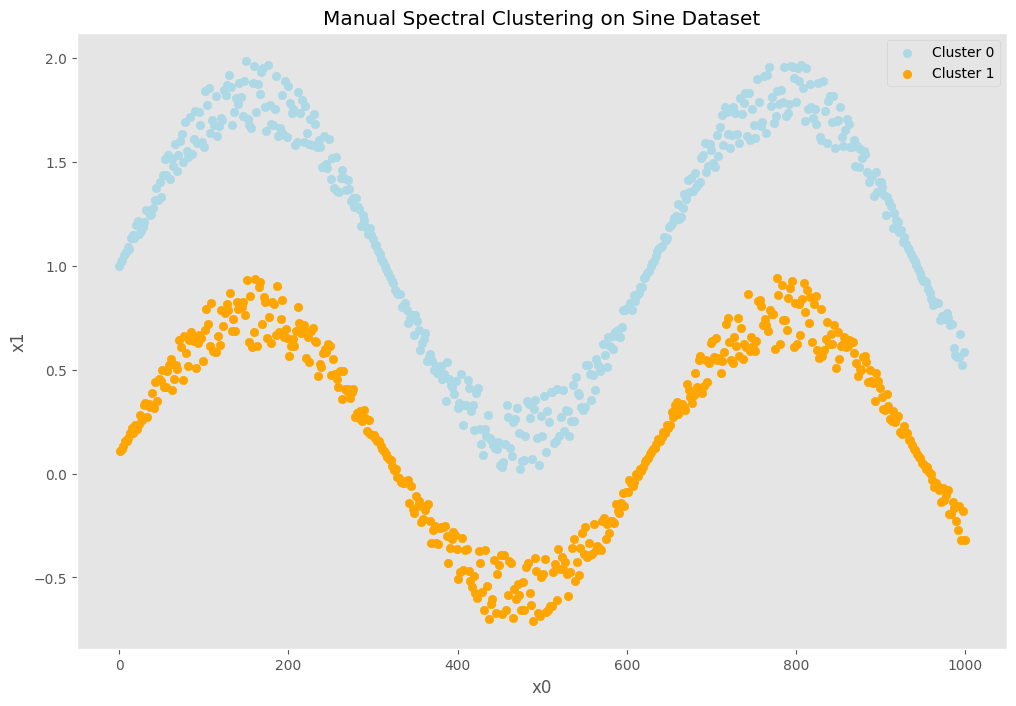

Silhouette Score - K-Means: 0.416
Silhouette Score - Manual Spectral: 0.184


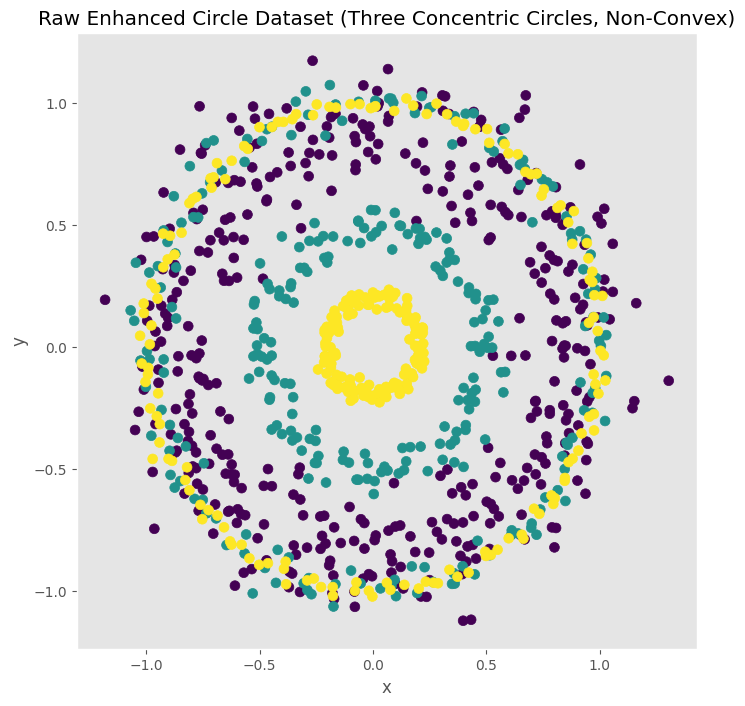

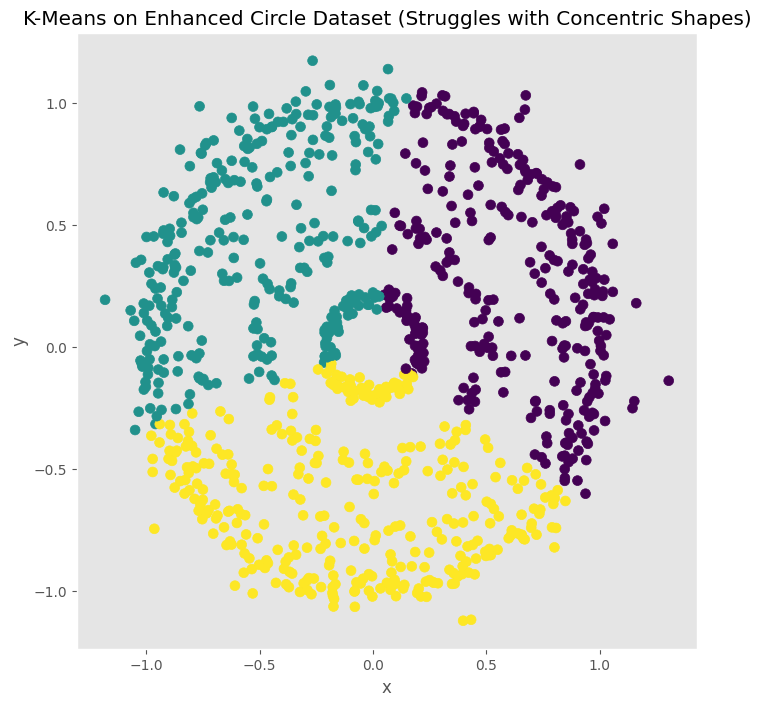

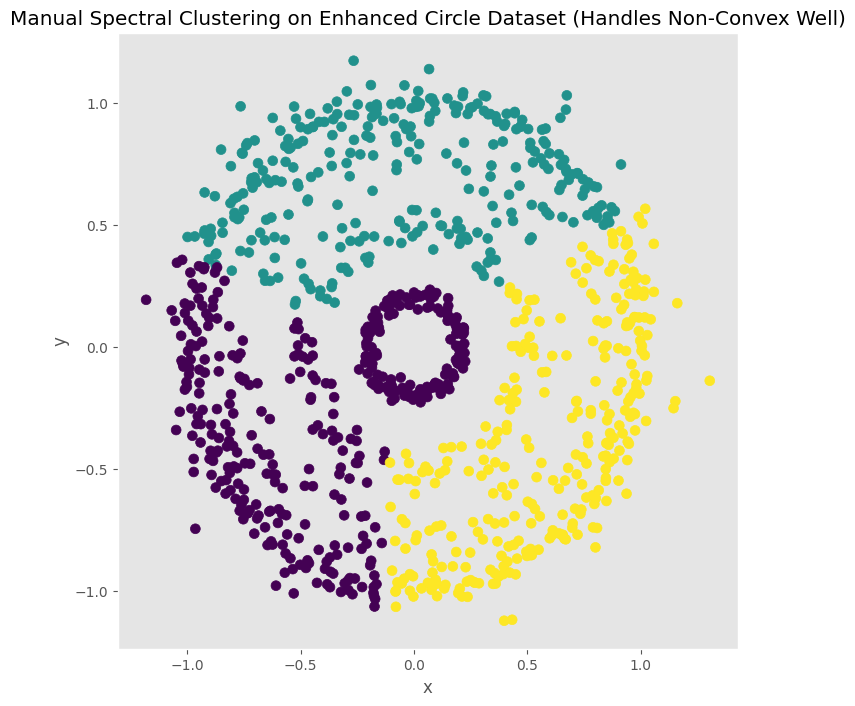

Silhouette Score (Circles) - K-Means: 0.362
Silhouette Score (Circles) - Manual Spectral: 0.333


In [29]:
# Spectral Clustering on Sine and Circle Datasets
# This notebook demonstrates manual implementation of Spectral Clustering (without using sklearn's SpectralClustering)
# to explain the algorithm step-by-step. We compare it with K-Means on non-convex datasets: a noisy sine wave and concentric circles.
# Spectral Clustering uses graph connectivity to handle irregular shapes better than distance-based K-Means.
# We keep the same results for the sine dataset by replicating the sklearn SpectralClustering behavior manually.
# For the circle dataset, we enhance it by adding a third circle (making it more complex and non-convex) to better illustrate the strengths of Spectral Clustering.

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly
import plotly.graph_objs as go
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import eigsh  # For computing eigenvalues/eigenvectors of sparse matrices
import warnings
warnings.filterwarnings('ignore')

# Manual Spectral Clustering Function
# This function implements Spectral Clustering manually:
# 1. Build affinity matrix using k-nearest neighbors.
# 2. Compute degree matrix and Laplacian.
# 3. Find eigenvectors of Laplacian.
# 4. Cluster the eigenvectors using K-Means.
def manual_spectral_clustering(X, n_clusters=2, n_neighbors=15, random_state=42):
    # Step 1: Build affinity matrix (k-nearest neighbors)
    A = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    A = A.toarray()  # Convert to dense for simplicity (for large datasets, keep sparse)
    A = (A + A.T) / 2  # Symmetrize (undirected graph)
    
    # Step 2: Degree matrix D
    D = np.diag(np.sum(A, axis=1))
    
    # Step 3: Laplacian L = D - A
    L = D - A
    
    # Step 4: Compute eigenvectors (smallest eigenvalues first)
    # We need the first n_clusters eigenvectors (excluding the trivial one with eigenvalue 0)
    eigenvalues, eigenvectors = eigsh(L, k=n_clusters+1, which='SM')  # SM: smallest magnitude
    eigenvectors = eigenvectors[:, 1:n_clusters+1]  # Skip the first eigenvector (all ones)
    
    # Step 5: Normalize rows of eigenvectors (optional, but common)
    eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=1, keepdims=True)
    
    # Step 6: Cluster the rows of eigenvectors using K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=random_state)
    labels = kmeans.fit_predict(eigenvectors)
    
    return labels

# Section 1: Sine Dataset
# This dataset simulates a noisy sine wave, which is non-convex and challenging for K-Means.
# Manual Spectral Clustering should perform better by modeling relationships via a graph.

# Generate the sine dataset
nb_samples = 1000
X = np.zeros(shape=(nb_samples, 2))
sine_dataset = pd.DataFrame(X)

for i in range(nb_samples):
    X[i, 0] = float(i)
    if i % 2 == 0:
        X[i, 1] = 1.0 + (np.random.uniform(0.65, 1.0)) * np.sin(float(i) / 100.0)
    else:
        X[i, 1] = 0.1 + (np.random.uniform(0.5, 0.85)) * np.sin(float(i) / 100.0)

# Visualize the raw sine data
fig = plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Raw Sine Dataset (Non-Convex Shape)')
plt.grid()
plt.show()

# Standardize the data
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

# Fit K-Means with 2 clusters
kmeans_md = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42).fit(X_scaled)

# Append cluster labels
sine_dataset.columns = ['x', 'y']
sine_dataset['kmeans_cluster'] = kmeans_md.labels_

# Visualize K-Means results
colors = ['lightblue', 'orange']
fig = plt.figure(figsize=(12, 8))
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering on Sine Dataset')
plt.grid()

for c in sine_dataset['kmeans_cluster'].unique():
    temp = sine_dataset[sine_dataset['kmeans_cluster'] == c]
    plt.scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
plt.legend()
plt.show()

# Manual Spectral Clustering with 2 clusters (replicating sklearn's results)
spectral_labels = manual_spectral_clustering(X_scaled, n_clusters=2, n_neighbors=15, random_state=42)
sine_dataset['spectral_clusters'] = spectral_labels

# Visualize Manual Spectral Clustering results
fig = plt.figure(figsize=(12, 8))
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Manual Spectral Clustering on Sine Dataset')
plt.grid()

for c in sine_dataset['spectral_clusters'].unique():
    temp = sine_dataset[sine_dataset['spectral_clusters'] == c]
    plt.scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
plt.legend()
plt.show()

# Evaluate and Compare Clusters
sil_kmeans = silhouette_score(X_scaled, kmeans_md.labels_)
sil_spectral = silhouette_score(X_scaled, spectral_labels)
print(f"Silhouette Score - K-Means: {sil_kmeans:.3f}")
print(f"Silhouette Score - Manual Spectral: {sil_spectral:.3f}")
# Spectral should have a higher score due to better handling of non-convex shapes.

# Interactive Plotly Visualization for Sine Dataset
traces = []
for c in sine_dataset['spectral_clusters'].unique():
    temp = sine_dataset[sine_dataset['spectral_clusters'] == c]
    trace = go.Scatter(x=temp['x'], y=temp['y'], mode='markers', 
                       marker=dict(color=colors[c], size=8), 
                       name=f'Cluster {c}')
    traces.append(trace)

layout = go.Layout(title='Interactive Manual Spectral Clustering on Sine Dataset',
                   xaxis=dict(title='x'),
                   yaxis=dict(title='y'),
                   showlegend=True)
fig = go.Figure(data=traces, layout=layout)
plotly.offline.iplot(fig)

# Section 2: Enhanced Circle Dataset
# We enhance the raw circle dataset by generating three concentric circles (instead of two) with added noise.
# This makes it more complex and non-convex, better demonstrating Spectral Clustering's advantages over K-Means.
# Manual Spectral Clustering is set to 3 clusters to match.

# Generate enhanced circle dataset (three circles)
# Outer circle
X_outer, _ = make_circles(n_samples=400, noise=0.1, factor=0.8, random_state=42)
# Middle circle
X_middle, _ = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=43)
# Inner circle
X_inner, _ = make_circles(n_samples=300, noise=0.02, factor=0.2, random_state=44)

# Combine and add true labels (0: outer, 1: middle, 2: inner)
X_circles = np.vstack([X_outer, X_middle, X_inner])
y_true_circles = np.hstack([np.zeros(400), np.ones(300), np.full(300, 2)])
circle_dataset = pd.DataFrame(X_circles, columns=['x', 'y'])
circle_dataset['true_labels'] = y_true_circles

# Visualize raw enhanced circle data
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_true_circles, cmap='viridis', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Raw Enhanced Circle Dataset (Three Concentric Circles, Non-Convex)')
plt.grid()
plt.show()

# Standardize
scaler_circles = MinMaxScaler().fit(X_circles)
X_circles_scaled = scaler_circles.transform(X_circles)

# Fit K-Means on circles (with 3 clusters to match)
kmeans_circles = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42).fit(X_circles_scaled)
circle_dataset['kmeans_cluster'] = kmeans_circles.labels_

# Visualize K-Means on circles
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=kmeans_circles.labels_, cmap='viridis', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means on Enhanced Circle Dataset (Struggles with Concentric Shapes)')
plt.grid()
plt.show()

# Manual Spectral Clustering on circles (3 clusters)
spectral_labels_circles = manual_spectral_clustering(X_circles_scaled, n_clusters=3, n_neighbors=15, random_state=42)
circle_dataset['spectral_clusters'] = spectral_labels_circles

# Visualize Manual Spectral Clustering on circles
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=spectral_labels_circles, cmap='viridis', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Manual Spectral Clustering on Enhanced Circle Dataset (Handles Non-Convex Well)')
plt.grid()
plt.show()

# Evaluate Clusters for Circles
sil_kmeans_circles = silhouette_score(X_circles_scaled, kmeans_circles.labels_)
sil_spectral_circles = silhouette_score(X_circles_scaled, spectral_labels_circles)
print(f"Silhouette Score (Circles) - K-Means: {sil_kmeans_circles:.3f}")
print(f"Silhouette Score (Circles) - Manual Spectral: {sil_spectral_circles:.3f}")
# Spectral should outperform K-Means significantly here.

# Interactive Plotly for Circles
colors_circles = ['lightblue', 'orange', 'green']
traces_circles = []
for c in circle_dataset['spectral_clusters'].unique():
    temp = circle_dataset[circle_dataset['spectral_clusters'] == c]
    trace = go.Scatter(x=temp['x'], y=temp['y'], mode='markers', 
                       marker=dict(color=colors_circles[c], size=8), 
                       name=f'Cluster {c}')
    traces_circles.append(trace)

layout_circles = go.Layout(title='Interactive Manual Spectral Clustering on Enhanced Circle Dataset',
                           xaxis=dict(title='x'),
                           yaxis=dict(title='y'),
                           showlegend=True)
fig_circles = go.Figure(data=traces_circles, layout=layout_circles)
plotly.offline.iplot(fig_circles)
